In [3]:
import numpy as np
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
def mahler_kernel(x,y,alpha):
    return np.exp(-(np.square(x)+np.square(y))/(2.*np.tanh(alpha))+x*y/np.sinh(alpha))/np.sqrt(np.pi*(1-np.exp(-2*alpha)))
def mahler_kernel_center_grad(x,y,alpha):
    return -(x+y)*(1/np.tanh(alpha)+1/np.sinh(alpha))*np.exp(-(np.square(x)+np.square(y))/(2.*np.tanh(alpha))+x*y/np.sinh(alpha))/np.sqrt(np.pi*(1-np.exp(-2*alpha)))
def confocal_projection(x,y,alpha, eta):
    return mahler_kernel(x,y,alpha) + np.exp(1j*np.pi*eta/2)*mahler_kernel(x,y,alpha-1j*np.pi/2) + np.exp(2j*np.pi*eta/2)*mahler_kernel(x,y,alpha-1j*np.pi) + np.exp(3j*np.pi*eta/2)*mahler_kernel(x,y,alpha+1j*np.pi/2)

def M_N_projection(x,y,alpha,eta, M, N):
    rslt = 0
    for s in range(N):
        rslt += np.exp(-1j*np.pi*eta*M/N)*mahler_kernel(x,y, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)*np.exp(-2j*np.pi*s*eta/N) + mahler_kernel(x,y, alpha - 1j*2*s*np.pi/N)*np.exp(-2j*np.pi*s*eta/N)
    return rslt/N

def M_N_projection_2d(x_in,x_out,y_in,y_out,source2D,alpha,eta, M, N):
    rslt = 0.j*source2D
    for s in range(N):
        term1_x = mahler_kernel(x_in,x_out, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)
        term1_y = mahler_kernel(y_in,y_out, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)
        term2_x = mahler_kernel(x_in,x_out, alpha - 1j*2*s*np.pi/N)
        term2_y = mahler_kernel(y_in,y_out, alpha - 1j*2*s*np.pi/N)
        rslt += np.exp(-1j*np.pi*eta*M/N)*term1_x @ source2D @ term1_y.T*np.exp(-2j*np.pi*s*eta/N) + term2_x @ source2D @ term2_y.T*np.exp(-2j*np.pi*s*eta/N)
    return rslt/N

def M_N_greens_fnc_2d(source_x,x_out,source_y,y_out,alpha,eta, M, N):
    rslt = 0.j*x_out
    assert(x_out.shape==y_out.shape)
    assert(len(x_out.shape)==2 and len(y_out.shape)==2)
    for s in range(N):
        term1_x = mahler_kernel(source_x,x_out, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)
        term1_y = mahler_kernel(source_y,y_out, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)
        term2_x = mahler_kernel(source_x,x_out, alpha - 1j*2*s*np.pi/N)
        term2_y = mahler_kernel(source_y,y_out, alpha - 1j*2*s*np.pi/N)
        rslt += np.exp(-1j*np.pi*eta*M/N)*term1_x * term1_y*np.exp(-2j*np.pi*s*eta/N) + term2_x * term2_y*np.exp(-2j*np.pi*s*eta/N)
    return rslt/N

def hermite_matrix(x):
    N = x.shape[0]
    num = np.arange(N)
    result = np.zeros((N,N))
    for n in range(0,N):
        if n < 15:
            poly = hermite(n)
            result[n] = np.exp(-np.square(x)/2.)*poly(x)
            norm = np.sqrt(np.power(2,n)*np.math.factorial(n)*np.sqrt(np.pi))
            print(norm)
            result[n] = result[n]/norm
        elif n < 100:
            poly = hermite(n)
            result[n] = np.exp(-np.square(x)/2.)*poly(x)
            norm = np.power(np.pi, 0.25)*np.power((2*n)/np.e, n/2.)
            print(norm)
            result[n] = result[n]/norm
        else:
            result[n] = np.sqrt(2)*np.cos(x*np.sqrt(2*n)-n*np.pi/2)*np.power(np.pi*(1-np.square(x)/(2*n+1)),-0.25)
    return result

def gaussian(x,x0, sigma):
    return np.exp(-np.square(x-x0)/(2*np.square(sigma)))/(np.sqrt(2*np.pi)*sigma)

def discrete_angle_transform(vecs):
    N = vecs.shape[0]
    multmatrix = np.einsum("i,j->ij", np.arange(N), np.arange(N))/N
    DFT = np.exp(-2j*np.pi*multmatrix)/np.sqrt(N)
    return DFT @ vecs

def SHO_hamiltonian(x):
    N = x.shape[0]
    dx = x[1]-x[0]
    p2 = (2*np.diag(np.ones(N)) - np.diag(np.ones(N-1),k=1) - np.diag(np.ones(N-1),k=-1))/(dx**2)
    x2 = np.diag(np.square(x))
    return (p2+x2)/2.

def discrete_wigner(dist, L=None):
    N = dist.shape[0]
    if L is None:
        L=N
    W = np.zeros((N,N), dtype=np.complex128)
    for n in range(0,N):
        bound = min(n, N-1-n)
        for m in range(-bound,bound+1):
            W[n,m] += dist[n+m]*np.conj(dist[n-m])*np.exp(-2j*np.pi*m/L)
    return W

In [5]:
def Hcomplex(z):# computes the hue corresponding to the complex number z
    H = np.angle(z) / (2*np.pi) + 1
    return np.mod(H, 1)

def complex2d_plot(field, ax=None):
    if ax is None:
        fig,ax = plt.subplots()
    H = Hcomplex(field)
    HSV = np.dstack((H,np.abs(field)/np.max(np.abs(field)),np.ones(field.shape)))
    RGB = hsv_to_rgb(HSV)
    plt.imshow(RGB,origin="lower")

In [6]:
x = np.linspace(-15.,15.,1000)
dx = x[1]-x[0]
y = np.linspace(-15.,15.,1000)
X,Y = np.meshgrid(x,y)
center = 1.0
proj_matrix = confocal_projection(X-center,Y-center,0.05,0)
ff_transform = mahler_kernel(X-center+0.1, Y-center+0.1,-1j*np.pi/2)
ff_transform_grad = mahler_kernel_center_grad(X-center+0.1, Y-center+0.1,-1j*np.pi/2)

In [7]:
field = proj_matrix[:,400]*dx

print(np.conjugate(field.T) @ np.conjugate(ff_transform_grad.T)*dx @ (ff_transform*dx - np.diag(np.ones(1000))) @ field)
err = (ff_transform*dx - np.diag(np.ones(1000))) @ field
print(np.conjugate(err.T) @ err)


(-0.1115767248762519+0.0011367689567328295j)
(0.01168866883592348+0j)


In [8]:
def find_cavity_center_1D(field, center_guess=0.4,err_bnd=1e-3,angle=np.pi/2):
    x = np.linspace(-15.,15.,1000)
    dx = x[1]-x[0]
    y = np.linspace(-15.,15.,1000)
    X,Y = np.meshgrid(x,y)
    ident = np.diag(np.ones(field.shape))
    def cavity_center_cost(center):
        ff_transform = mahler_kernel(X-center, Y-center,-1j*angle)
        err = (ff_transform*dx - ident) @ field
        cost = np.conjugate(err.T) @ err
        # print("\nCenter: ",center, "\nCost: ",cost)
        return cost
    def cavity_center_grad(center):
        ident = np.diag(np.ones(field.shape))
        ff_transform = mahler_kernel(X-center, Y-center,-1j*angle)
        ff_transform_grad = mahler_kernel_center_grad(X-center, Y-center,-1j*angle)
        grad = np.real(np.conjugate(field.T) @ np.conjugate(ff_transform_grad.T*dx) @ (ff_transform*dx - ident) @ field)
        return grad
    rslt = minimize(cavity_center_cost, [center_guess], jac=cavity_center_grad)
    print(rslt)
    return rslt

def find_cavity_center_2D(field, center_guess=[0.4,0.4],err_bnd=1e-3,N=1,M=2, eta=0.0, xmin=-15.,xmax=15.,ymin=-15.,ymax=15.):
    x = np.linspace(xmin,xmax,field.shape[0])
    dx = x[1]-x[0]
    y = np.linspace(ymin,ymax,field.shape[1])
    X,Y = np.meshgrid(x,y)
    def cavity_center_cost(center):
        ff_transform_x = mahler_kernel(X-center[0], Y-center[0],-1j*M/N*np.pi)
        ff_transform_y = mahler_kernel(X-center[1], Y-center[1],-1j*M/N*np.pi)
        err = np.exp(-1j*eta*np.pi*M/N)*ff_transform_x*dx @ field @ ff_transform_y*dx - field
        cost = np.linalg.norm(err)**2
        # print("\nCenter: ",center, "\nCost: ",cost)
        return cost
    # def cavity_center_grad(center):
    #     ident = np.diag(np.ones(field.shape))
    #     ff_transform = mahler_kernel(X-center, Y-center,-1j*np.pi/2)
    #     ff_transform_grad = mahler_kernel_center_grad(X-center, Y-center,-1j*np.pi/2)
    #     grad = np.real(np.conjugate(field.T) @ np.conjugate(ff_transform_grad.T*dx) @ (ff_transform*dx - ident) @ field)
    #     return grad
    rslt = minimize(cavity_center_cost, center_guess)
    print(rslt)
    complex2d_plot(np.exp(-1j*eta*np.pi*M/N)*ff_transform_x*dx @ field @ ff_transform_y*dx)
    return rslt

def cavity_center_GD(field, center_guess=0.4,err_bnd=1e-3):
    x = np.linspace(-15.,15.,1000)
    dx = x[1]-x[0]
    y = np.linspace(-15.,15.,1000)
    X,Y = np.meshgrid(x,y)
    ident = np.diag(np.ones(field.shape))
    center = center_guess
    cost = np.inf
    step = 0
    while cost > err_bnd and step < 10000:
        ff_transform = mahler_kernel(X-center, Y-center,-1j*np.pi/2)
        ff_transform_grad = mahler_kernel_center_grad(X-center, Y-center,-1j*np.pi/2)
        grad = np.real(np.conjugate(field.T) @ np.conjugate(ff_transform_grad.T*dx) @ (ff_transform*dx - ident) @ field)
        print("\nGradient: ", grad)
        center = center - grad
        ff_transform = mahler_kernel(X-center, Y-center,-1j*np.pi/2)
        cost = np.sum(np.abs(np.square((ff_transform*dx - ident)@field)))
        print("Center: ",center, "\nCost: ",cost)
        step += 1

In [13]:
rslt = find_cavity_center_1D(proj_matrix[:,200]*dx + 0.001*np.random.rand(1000))
rslt["x"]

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: (0.002352243857066053+0j)
        x: [ 3.969e-01]
      nit: 2
      jac: [ 8.059e-07]
 hess_inv: [[ 2.543e+01]]
     nfev: 4
     njev: 4


array([0.39688493])

In [14]:
x_in = np.linspace(-15.,15.,1000)
dx = x_in[1]-x_in[0]
x_out = np.linspace(-15.,15.,1000)
X_in,X_out = np.meshgrid(x_in,x_out)

y_in = np.linspace(-15.,15.,1000)
dy = y_in[1]-y_in[0]
y_out = np.linspace(-15.,15.,1000)
Y_in,Y_out = np.meshgrid(y_in,y_out)


sources = np.zeros((1000,1000),dtype=np.complex128)
sources[500,500] = 1.0
center = [1.0,-0.4]
field2D = M_N_projection_2d(X_in-center[0],X_out-center[0],Y_in-center[1],Y_out-center[1],sources,0.05,1,4,7)

In [15]:
find_cavity_center_2D(field2D+0.01*np.random.rand(1000,1000), M=4,N=7, eta=1)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 58.580522732521764
        x: [ 1.000e+00 -4.000e-01]
      nit: 11
      jac: [ 1.431e-06  4.768e-07]
 hess_inv: [[ 3.325e-05  1.859e-06]
            [ 1.859e-06  3.696e-05]]
     nfev: 48
     njev: 16


NameError: name 'ff_transform_x' is not defined

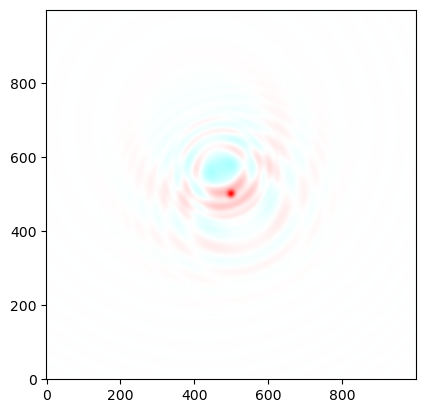

In [74]:
complex2d_plot(field2D)

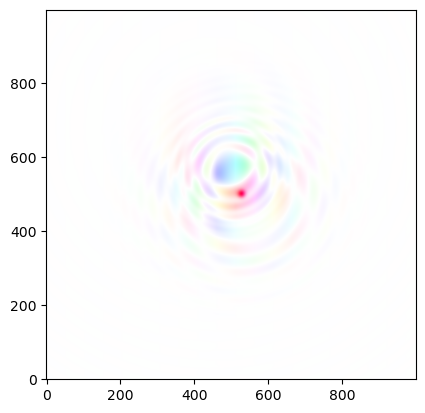

In [75]:
ff_transform_x = mahler_kernel(X_in-1., X_out-1.,-1j*np.pi*4/7)
ff_transform_y = mahler_kernel(Y_in-0.3, Y_out-0.3,-1j*np.pi*4/7)
complex2d_plot(np.exp(-1j*4*np.pi/7)*ff_transform_x*dx @ field2D @ ff_transform_y*dx)

In [20]:
fields = np.load("Fields.npy")
avgField = np.load("AvgField.npy")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3241.8373452970545
        x: [-2.813e-02  1.532e+00]
      nit: 9
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 3.970e-03 -2.714e-03]
            [-2.714e-03  4.132e-03]]
     nfev: 36
     njev: 12


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3241.8373452970545
        x: [-2.813e-02  1.532e+00]
      nit: 9
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 3.970e-03 -2.714e-03]
            [-2.714e-03  4.132e-03]]
     nfev: 36
     njev: 12

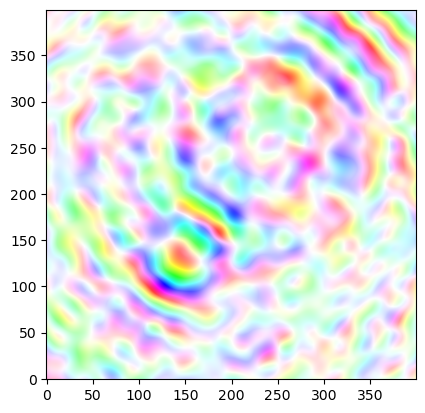

In [23]:
find_cavity_center_2D(fields[0], M=4,N=7, eta=0)

In [105]:
dx = 13e-6/(34.8e-6*7.100)
x_in = np.linspace(-200*dx,200.*dx,400)
x_out = np.linspace(-200*dx,200.*dx,400)
X_in,X_out = np.meshgrid(x_in,x_out)

y_in = np.linspace(-200*dx,200.*dx,400)
y_out = np.linspace(-200*dx,200.*dx,400)
Y_in,Y_out = np.meshgrid(y_in,y_out)

sources = np.zeros((400,400),dtype=np.complex128)
sources[200,200] = 1.
sources[210,200] = 1.
sources[220,200] = -1.
sources[240,200] = 1.

sources[200,230] = -1.
sources[210,230] = 1.
sources[220,230] = -1.
sources[240,230] = 1.

center = [1.2,1.2]
field2D = M_N_projection_2d(X_in+1.1,X_out,Y_in,Y_out,sources,0.02,0,4,7)

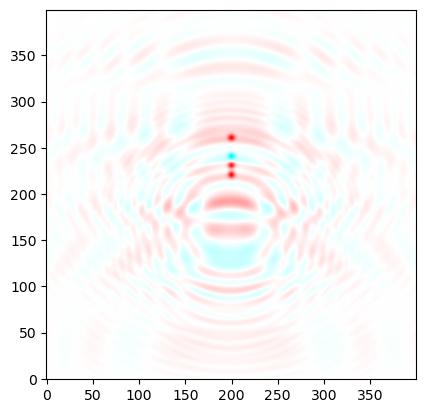

In [85]:
complex2d_plot(field2D)

In [106]:
cond1 = (np.square(X_out-1.1-X_out[200,200])+np.square(Y_in-Y_in[200,200]))<0.2
cond2 = (np.square(X_out-1.1-X_out[210,200])+np.square(Y_in-Y_in[210,200]))<0.2
cond3 = (np.square(X_out-1.1-X_out[220,200])+np.square(Y_in-Y_in[220,200]))<0.2
cond4 = (np.square(X_out-1.1-X_out[240,200])+np.square(Y_in-Y_in[240,200]))<0.2

cond12 = (np.square(X_out-1.1-X_out[200,230])+np.square(Y_in-Y_in[200,230]))<0.2
cond22 = (np.square(X_out-1.1-X_out[210,230])+np.square(Y_in-Y_in[210,230]))<0.2
cond32 = (np.square(X_out-1.1-X_out[220,230])+np.square(Y_in-Y_in[220,230]))<0.2
cond42 = (np.square(X_out-1.1-X_out[240,230])+np.square(Y_in-Y_in[240,230]))<0.2

cond = np.logical_or.reduce((cond1, cond2, cond3, cond4, cond12, cond22, cond32, cond42))
mask = np.piecewise(X_out, [cond, np.logical_not(cond)], [0.,1.])

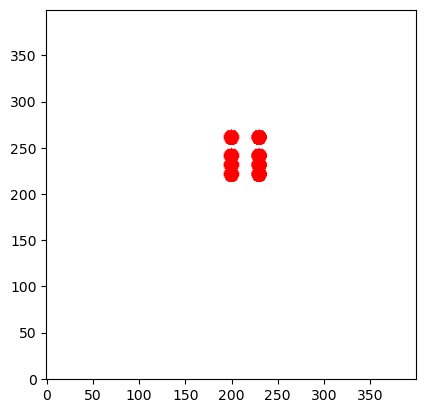

In [107]:
complex2d_plot(cond)

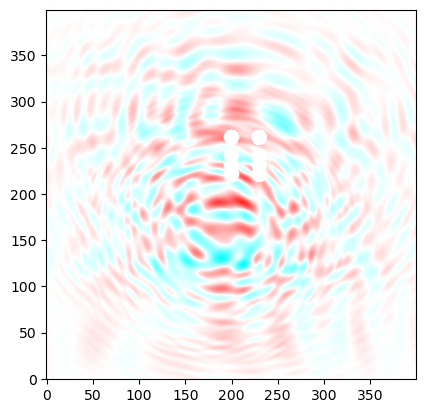

In [108]:
complex2d_plot(field2D*mask)

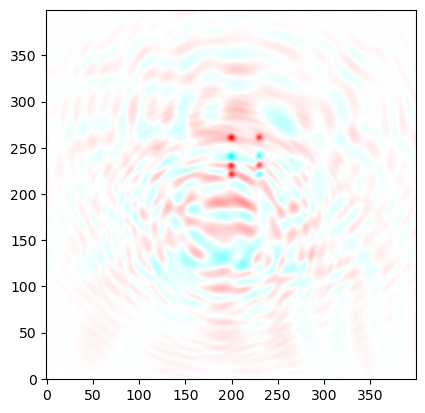

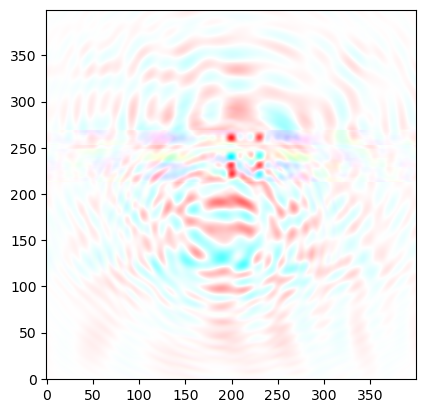

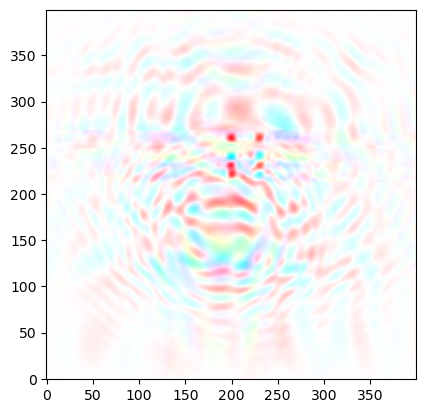

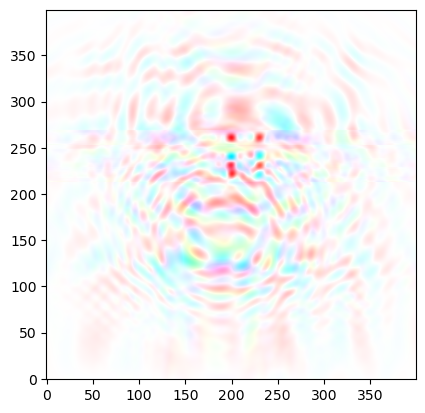

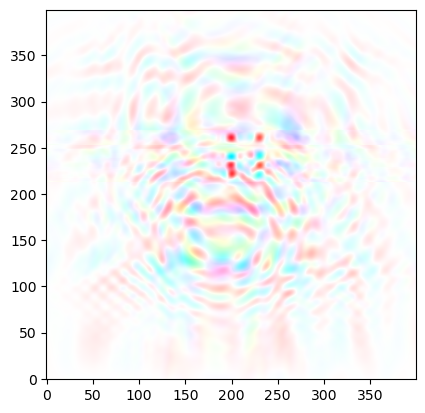

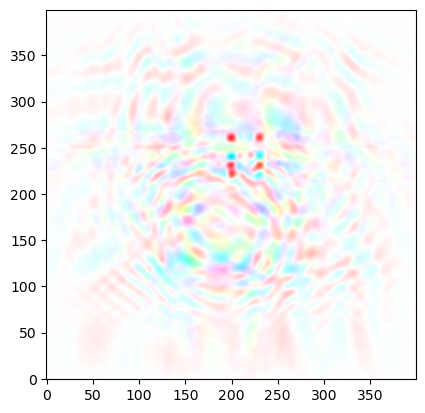

In [109]:
ff_transform_x = mahler_kernel(X_in, X_out,-1j*np.pi*4/7)
ff_transform_y = mahler_kernel(Y_in, Y_out,-1j*np.pi*4/7)
def mask_filter(field2D):
    return ff_transform_x*dx @ field2D*mask @ ff_transform_y*dx

curr_field = field2D
complex2d_plot(curr_field)
for i in range(1,6):
    curr_field = mask_filter(curr_field)
    complex2d_plot(curr_field)

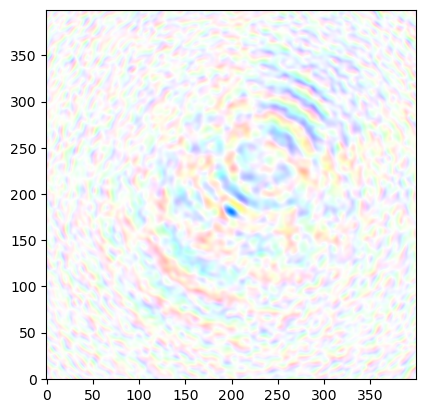

In [105]:
fig, ax = plt.subplots()
complex2d_plot(fields[0], ax=ax)
# ax.set_xticks(np.linspace(-200*dx,200.*dx,20))
# ax.set_yticks(np.linspace(-200*dx,200.*dx,20))

In [59]:
def curve_fit_func(pos,*p):
    # p[0] source x
    # p[1] source y
    # p[2] center x
    # p[3] center y
    # p[4] w0 (cavity width)
    # p[5] alpha (source thickness)
    # p[6] phi
    X,Y = pos.reshape((400,400,2)).swapaxes(0,2).swapaxes(1,2)
    outfield = np.exp(1j*p[6])*M_N_greens_fnc_2d((p[0]-p[2])/p[4],(X-p[2])/p[4],(p[1]-p[3])/p[4],(Y-p[3])/p[4],p[5],0,4,7)
    rslt = outfield.ravel()
    # print(rslt)
    return rslt

dx = 13e-6/(34.467e-6*11.000)
x = np.linspace(-200*dx,200.*dx,400)
y = np.linspace(-200*dx,200.*dx,400)
X,Y = np.meshgrid(x,y)

pos = np.dstack((X.ravel(),Y.ravel()))
p0 = np.array([0., 0., 1.2, 1.2, 1.,
        0.01])


curve_fit(curve_fit_func, pos, fields[2].ravel(), p0)

/Users/henryhunt/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/var/folders/4w/vyhp34ws43v7kxy3v5hv8y740000gn/T/ipykernel_49940/4043439167.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(-(np.square(x)+np.square(y))/(2.*np.tanh(alpha))+x*y/np.sinh(alpha))/np.sqrt(np.pi*(1-np.exp(-2*alpha)))
/var/folders/4w/vyhp34ws43v7kxy3v5hv8y740000gn/T/ipykernel_49940/4043439167.py:2: RuntimeWarning: invalid value encountered in divide
  return np.exp(-(np.square(x)+np.square(y))/(2.*np.tanh(alpha))+x*y/np.sinh(alpha))/np.sqrt(np.pi*(1-np.exp(-2*alpha)))
/var/folders/4w/vyhp34ws43v7kxy3v5hv8y740000gn/T/ipykernel_49940/4043439167.py:33: RuntimeWarning: overflow encountered in multiply
  rslt += np.exp(-1j*np.pi*eta*M/N)*term1_x * term1_y*np.exp(-2j*np.pi*s*eta/N) + term2_x * term2_y*np.exp(-2j*np.pi*s*eta/N)
/var/folders/4w/vyhp34ws43v7kxy

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


(array([ 0.05703003, -0.6834715 ,  0.67834209,  0.33707909,  0.68047997,
         0.03584048]),
 array([[ 7.34730555e-07, -1.21771851e-08,  4.60038210e-07,
         -5.21979462e-08, -1.48274614e-08, -9.42814788e-10],
        [-1.21771851e-08,  7.22118092e-07, -5.31996283e-08,
          4.05959338e-07, -2.47987994e-08, -1.53473178e-09],
        [ 4.60038210e-07, -5.31996283e-08,  4.61208411e-07,
         -5.33788357e-08,  1.57833712e-10, -4.42931422e-11],
        [-5.21979462e-08,  4.05959338e-07, -5.33788357e-08,
          4.06246204e-07, -3.25891793e-10, -4.43107115e-11],
        [-1.48274614e-08, -2.47987994e-08,  1.57833712e-10,
         -3.25891793e-10,  1.62954480e-08,  7.88985429e-10],
        [-9.42814788e-10, -1.53473178e-09, -4.42931422e-11,
         -4.43107115e-11,  7.88985429e-10,  1.76948482e-08]]))

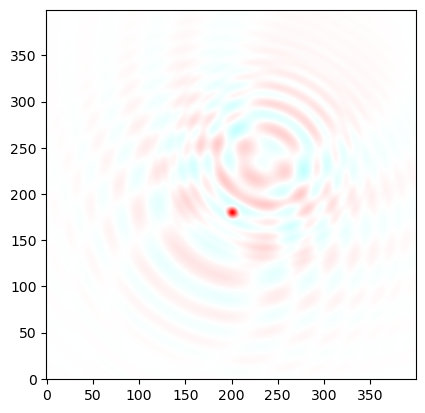

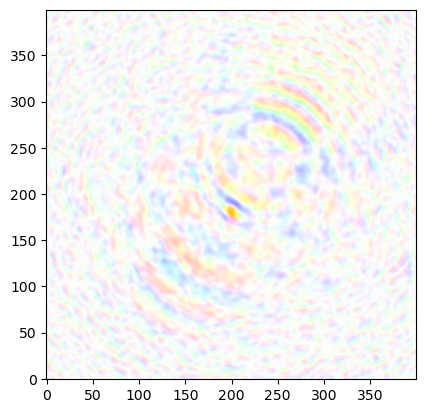

In [60]:
p =  [0.05703003, -0.6834715 ,  0.67834209,  0.33707909,  0.68047997,
         0.03584048]#[0., 0., 1.2, 1.2, 1., 0.01]
complex2d_plot(M_N_greens_fnc_2d((p[0]-p[2])/p[4],(X-p[2])/p[4],(p[1]-p[3])/p[4],(Y-p[3])/p[4],p[5],0,4,7))
complex2d_plot(fields[2])

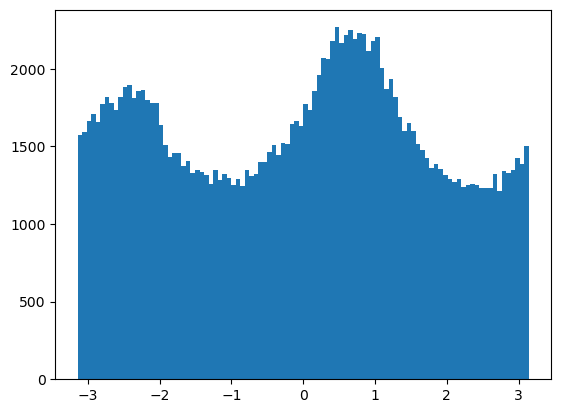

In [51]:
out = plt.hist(np.angle(fields[2]).ravel(), bins=100)

In [37]:
centers = np.linspace(0.,5.,100)
X,Centers = np.meshgrid(x, centers)

In [6]:
gaussian_transform = gaussian(X,Centers, 0.1)

In [7]:
np.linalg.matrix_rank(proj_matrix @ gaussian_transform.T)

99

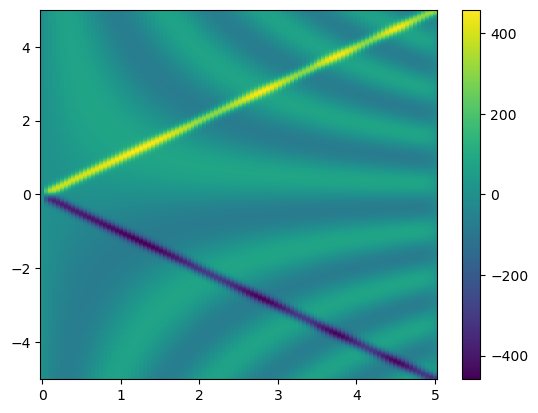

In [8]:
plt.pcolor(centers, x, np.real(proj_matrix @ gaussian_transform.T))
plt.colorbar()

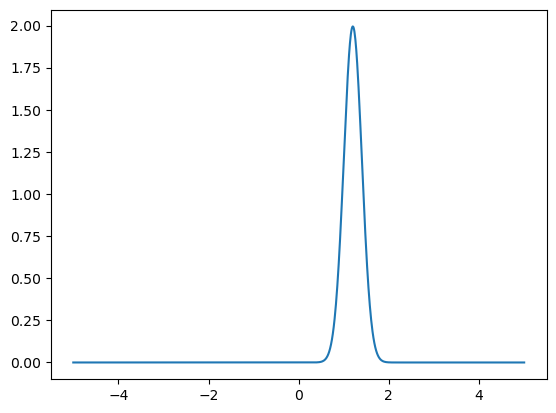

In [9]:
plt.plot(x, np.real(gaussian(x, 1.2,0.2)))

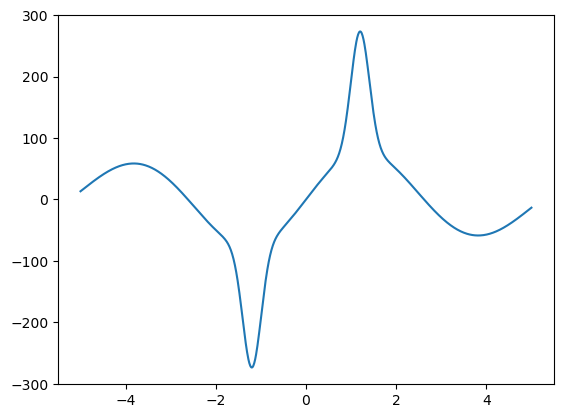

In [10]:
plt.plot(x, np.real(proj_matrix @ gaussian(x, 1.2,0.2)))

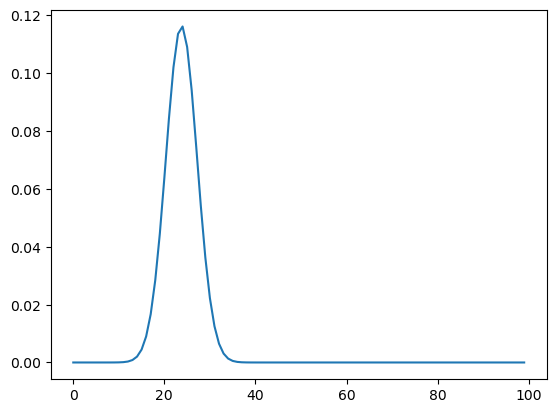

In [11]:
plt.plot(np.real(np.linalg.pinv(proj_matrix @ gaussian_transform.T) @ proj_matrix @ gaussian(x, 1.2,0.2)))

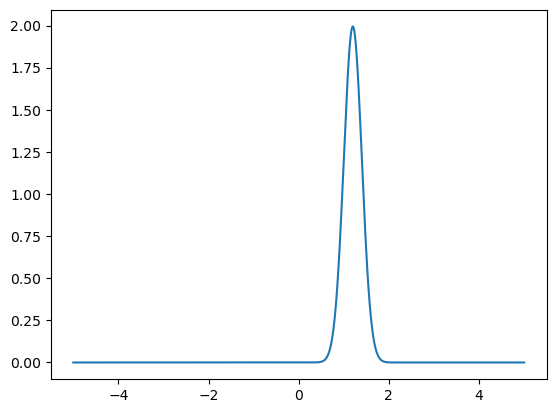

In [12]:
plt.plot(x, np.real(gaussian_transform.T @ np.linalg.pinv(proj_matrix @ gaussian_transform.T) @ proj_matrix @ gaussian(x, 1.2,0.2)))

In [113]:
x = np.linspace(-5.,5.,1000)
y = np.linspace(-5.,5.,1000)
X,Y = np.meshgrid(x,y)
proj_matrix = M_N_projection(X,Y,0.01,0, 4, 7)

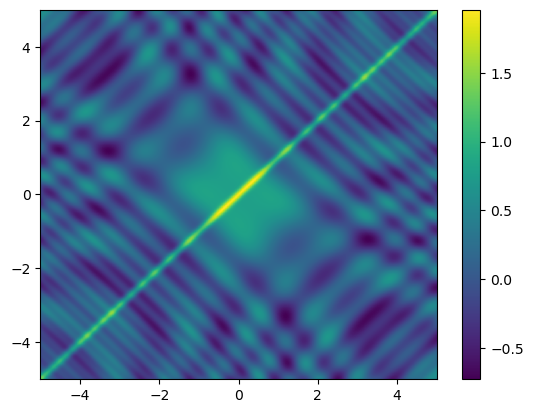

In [421]:
plt.pcolor(x,y,np.real(proj_matrix))
plt.colorbar()

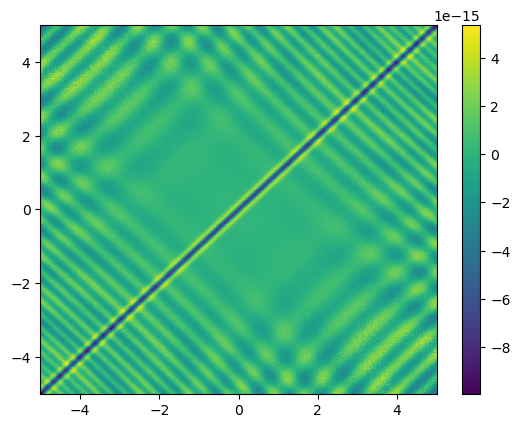

In [422]:
plt.pcolor(x,y,np.imag(proj_matrix))
plt.colorbar()

In [423]:
centers = np.linspace(0.,5.,100)
X,Centers = np.meshgrid(x, centers)

In [424]:
gaussian_transform = gaussian(X,Centers, 0.1)
np.linalg.matrix_rank(proj_matrix @ gaussian_transform.T)

84

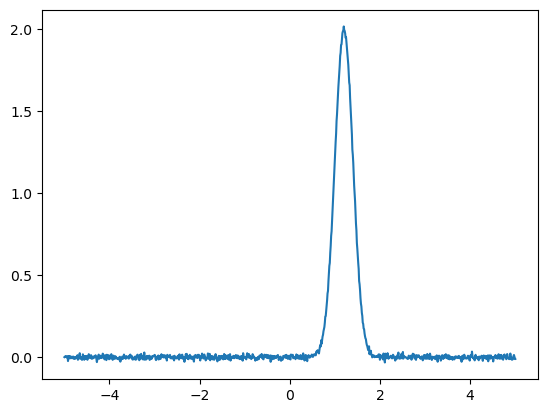

In [14]:
plt.plot(x, np.real(gaussian(x, 1.2,0.2)+np.random.normal(0.0,0.01,1000)))

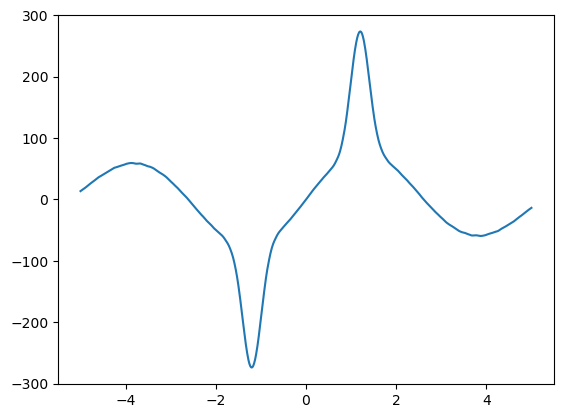

In [16]:
plt.plot(x, np.real(proj_matrix @ (gaussian(x, 1.2,0.2)+np.random.normal(0.0,0.01,1000))))

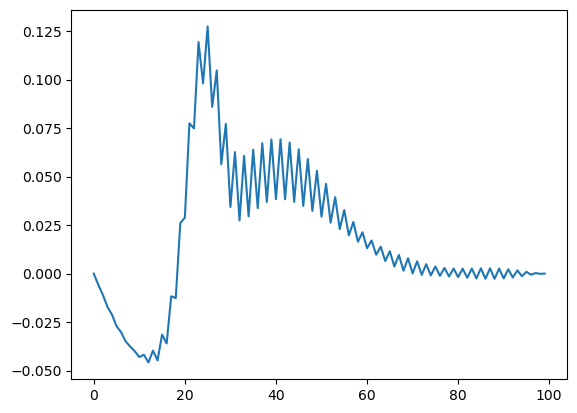

In [53]:
plt.plot(np.real(np.linalg.pinv(proj_matrix @ gaussian_transform.T) @ proj_matrix @ (gaussian(x, 1.2,0.2) + np.random.normal(0.0,0.00000001,1000))))

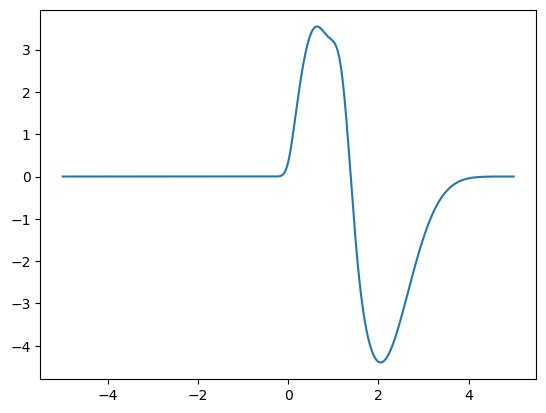

In [56]:
plt.plot(x, np.real(gaussian_transform.T @ np.linalg.pinv(proj_matrix @ gaussian_transform.T) @ proj_matrix @ (gaussian(x, 1.2,0.2) + np.random.normal(0.0,0.0000001,1000))))

In [404]:
np.linalg.norm(gaussian_transform.T @ np.linalg.pinv(proj_matrix @ gaussian_transform.T))

1049733379061.5702

In [402]:
np.linalg.norm(np.linalg.pinv(proj_matrix @ gaussian_transform.T))

74494052215.18419

In [20]:
U,S,Vh = np.linalg.svd(proj_matrix)

In [21]:
proj_matrix @ Vh

array([[-0.99086327+2.37577826e-16j,  0.03997885+2.22673534e-02j,
        -1.80940023-2.54799186e-02j, ...,  0.81158213-1.87324762e-02j,
        -2.92092045+2.06407392e-02j,  0.99854044+2.01335638e-04j],
       [-1.17519194+2.46131354e-16j, -0.09579244+2.25388408e-02j,
        -1.93950936-2.60257451e-02j, ...,  0.93118221-1.93311700e-02j,
        -2.80240513+2.09249488e-02j,  1.17117002+1.99764023e-04j],
       [-1.36059552+2.70122620e-16j, -0.23435123+2.28482792e-02j,
        -2.07099561-2.66195171e-02j, ...,  1.05274565-1.99741765e-02j,
        -2.68045497+2.12462412e-02j,  1.34450566+1.98299594e-04j],
       ...,
       [ 1.36059552-2.06128959e-14j,  0.23435123-2.28482792e-02j,
         2.07099561+2.66195171e-02j, ..., -1.05274565+1.99741765e-02j,
         2.68045497-2.12462412e-02j, -1.34450566-1.98299594e-04j],
       [ 1.17519194+2.48359451e-16j,  0.09579244-2.25388408e-02j,
         1.93950936+2.60257451e-02j, ..., -0.93118221+1.93311700e-02j,
         2.80240513-2.09249488e-02j

In [327]:
gaussian_transform.shape

(100, 1000)

In [152]:
x_in = np.linspace(-5.,5.,1000)
dx = x_in[1] - x_in[0]
x_out = np.linspace(-5.,5.,1000)
X_in,X_out = np.meshgrid(x_in,x_out)
proj_matrix = M_N_projection(X_in,X_out,0.01,3, 4, 7)

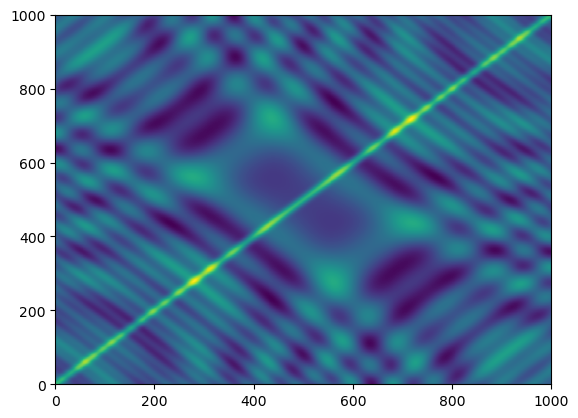

In [131]:
plt.pcolor(np.real(proj_matrix))

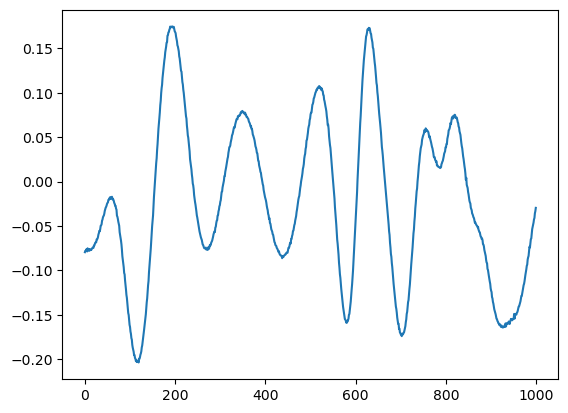

In [219]:
actual_source = gaussian(x_in, 1.2,0.2)
actual_source = actual_source/np.sqrt(np.dot(actual_source, actual_source)*dx)
input_field = proj_matrix @ actual_source*dx + np.random.normal(0.0,0.001,1000)
plt.plot(np.real(input_field))

In [221]:
print(np.dot(input_field,input_field)*dx)
print(np.dot(actual_source, actual_source)*dx)

(0.09119242514638098-2.396894795761454e-16j)
0.9999999999999999


In [222]:
print(cost_function(input_field, input_field, proj_matrix, dx, 1.0, 0.1, 1.0))
print(cost_function(input_field, gaussian(x_in, 1.2,0.2), proj_matrix, dx, 1.0, 0.1, 1.0))

(242111.44493975345-1.1513016080121945e-09j)
(125953.54786069908-3.3122930823088745e-10j)


In [271]:
def gradient_discent_leastsq(observed_field, source_field_guess, cavity_map, dx, a,b,c, max_iter=10000, err_bound=0.1, momentum=0.001, source_mag=1.):
    i = 0
    source_mag = np.dot(observed_field, observed_field)
    converged = False
    source_field = np.copy(source_field_guess)
    while not converged and i < max_iter:
        step = min(i, steps-1)
        dis = -2*a[step]*cavity_map.T @ (cavity_map @ source_field - observed_field)
        print(np.linalg.norm(dis))
        if np.linalg.norm(dis) < err_bound:
            converged = True
        if np.isnan(np.linalg.norm(dis)):
            print("Algorithm diverged")
            return source_field
        source_field += momentum*dis
        i += 1
    return source_field

In [ ]:
def cost_function(observed_field, source_field, cavity_map, dx, a,b,c, source_mag=1.):
    v1 = observed_field - cavity_map @ source_field
    return a*np.dot(v1,v1)-b*np.sum(np.power(source_field,4))+c*np.square(source_mag-np.dot(source_field, source_field)*dx)

def gradient_discent_phi4(observed_field, source_field_guess, cavity_map, dx, a,b,c, max_iter=10000, steps=1000, err_bound=0.1, momentum=0.001, source_mag=1.):
    i = 0
    source_mag = np.dot(observed_field, observed_field)
    converged = False
    source_field = np.copy(source_field_guess)
    while not converged and i < max_iter:
        step = min(i, steps-1)
        dis = -2*a[step]*cavity_map.T @ (cavity_map @ source_field - observed_field)+4*b[step]*np.sum(np.power(source_field,3))*dx+2*c[step]*(np.dot(source_field, source_field)*dx - source_mag)*2*source_field*dx
        print(np.linalg.norm(dis))
        if i > steps and np.linalg.norm(dis) < err_bound:
            converged = True
        if np.isnan(np.linalg.norm(dis)):
            print("Algorithm diverged")
            return source_field
        source_field += momentum*dis
        i += 1
    return source_field

In [265]:
columb_matrix = 1/np.abs(X_in - X_out)
for i in range(columb_matrix.shape[0]):
    columb_matrix[i,i] = 0.

/var/folders/4w/vyhp34ws43v7kxy3v5hv8y740000gn/T/ipykernel_41055/668990133.py:1: RuntimeWarning: divide by zero encountered in true_divide
  columb_matrix = 1/np.abs(X_in - X_out)


In [282]:
def cost_function(observed_field, source_field, cavity_map, dx, a,b,c, source_mag=1.):
    v1 = observed_field - cavity_map @ source_field
    return a*np.dot(v1,v1)+c*np.square(source_mag-np.dot(source_field, source_field)*dx)

def gradient_discent_actraction(observed_field, source_field_guess, cavity_map, dx, a,b,c, max_iter=10000, steps=1000, err_bound=0.1, momentum=0.01, source_mag=1.):
    i = 0
    source_mag = np.dot(observed_field, observed_field)
    converged = False
    source_field = np.copy(source_field_guess)
    while not converged and i < max_iter:
        step = min(i, steps-1)
        dis = -2*a[step]*cavity_map.T @ (cavity_map @ source_field - observed_field)-4*b[step]* np.diag(source_field) @ columb_matrix.T @ np.power(source_field,2)*dx+2*c[step]*(np.dot(source_field, source_field)*dx - source_mag)*2*source_field*dx
        print(np.linalg.norm(dis))
        if i > steps and np.linalg.norm(dis) < err_bound:
            converged = True
        if np.isnan(np.linalg.norm(dis)):
            print("Algorithm diverged")
            return source_field
        source_field += momentum*dis
        i += 1
    return source_field

In [280]:
steps = 1000
t = np.arange(1000)/1000
a = t**2
b = np.exp(-t/0.1)
c = np.exp(-t/0.1)
source_field = gradient_discent_actraction(input_field, np.array(gaussian(x_in, 1.1,0.2) + np.random.normal(0.0,0.1,1000), dtype=np.complex128), proj_matrix*dx, dx, a, b, c)

1034.6050969253909
767.0619587381789
602.7572965462757
492.02344557495064
412.66155854434555
353.2204747445114
307.1914434010061
270.60370867864145
240.89992204603453
216.36064503956538
195.7885756123872
178.3253277648541
163.34012849485921
150.35955217503727
139.02168566850509
129.0453736603639
120.20906827131635
112.33596498416287
105.28335359475224
98.93485662152881
93.1946840764608
87.9833208575905
83.23424808775906
78.89142138636075
74.90731055051839
71.24136064214805
67.85877289949526
64.72953086616631
61.8276163210774
59.13037341410243
56.61798948090065
54.27306842371661
52.08027805761735
50.026056959221556
48.098369487670666
46.28650003896609
44.5808794344209
42.97293776949147
41.45497916151373
40.02007470837936
38.66197066045069
37.37500935667739
36.154060914432314
34.99446401498879
33.89197441117941
32.842720014756644
31.843161609294633
30.890058388686636
29.9804376481143
29.11156805908227
28.28093604691278
27.486224861314053
26.725295990938285
25.996172623370015
25.297024894

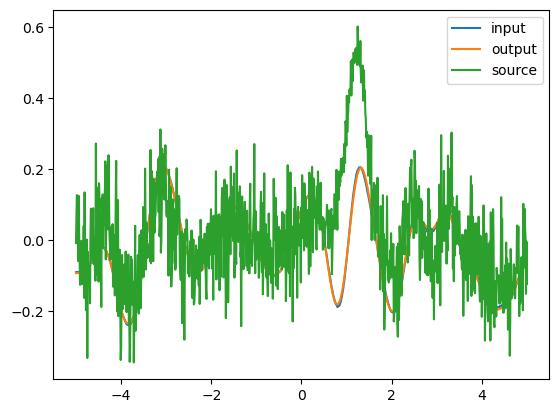

In [283]:
plt.plot(x_in, np.real(input_field), label="input")
plt.plot(x_in, np.real(proj_matrix @ source_field*dx), label="output")
plt.plot(x_in, np.real(source_field), label="source")
plt.legend()

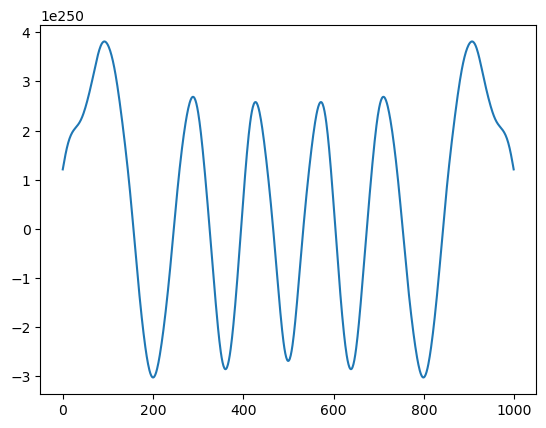

In [244]:
plt.plot(proj_matrix @ source_field)